Participated this ml problem task in ReliSource Gulshan office

LGBMRegressor(max_depth=5, n_estimators=300, num_leaves=64, random_state=42) #best parameters
from ensemble predictions of XGB,RF and LGBM (DATA-AUGMENTATION adding noise) + strtified k (5) fold
Lowest 
Public score: 7879578046758.0195 on Kaggle Competition so used different parameters (searching) below:



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

import itertools
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
# Loading training dataset
train_data = pd.read_csv('train.csv')

train_data.head()

Id  col4  col6 col9        col1  col8  col3  col7        y
0   1  2107   5.0   B0  2014-03-10   3.0    A0     2  1300000
1   2  2106   4.0   B0  2017-11-20   2.0  A453     2  2250000
2   3  2110   5.0   B0  2017-02-20   2.0  A371     4  3800000
3   4  2048   3.0   B0  2012-01-31   2.0  A508     1   790000
4   5  2146   2.0   B1  2017-07-04   1.0  A548     2   615000

In [3]:
# Splitting the training data into features (X_train) and target (y_train)
X_train = train_data.drop(['Id', 'y'], axis=1)
y_train = train_data['y']

In [4]:
# Loading test dataset
test_data = pd.read_csv('test.csv')

test_data.head()

Id  col4  col6 col9        col1  col8  col3  col7
0  139653  2228   6.0   B0  2017-04-01   1.0  A433     3
1  139654  2190   2.0   B0  2010-09-18   1.0  A601     1
2  139655  2035   3.0   B0  2016-10-25   2.0  A220     1
3  139656  2035   3.0   B0  2019-04-18   2.0  A220     2
4  139657  2117   4.0   B0  2014-10-02   1.0  A447     1

In [5]:
# Splitting the test data into features (X_test)
X_test = test_data.drop('Id', axis=1)

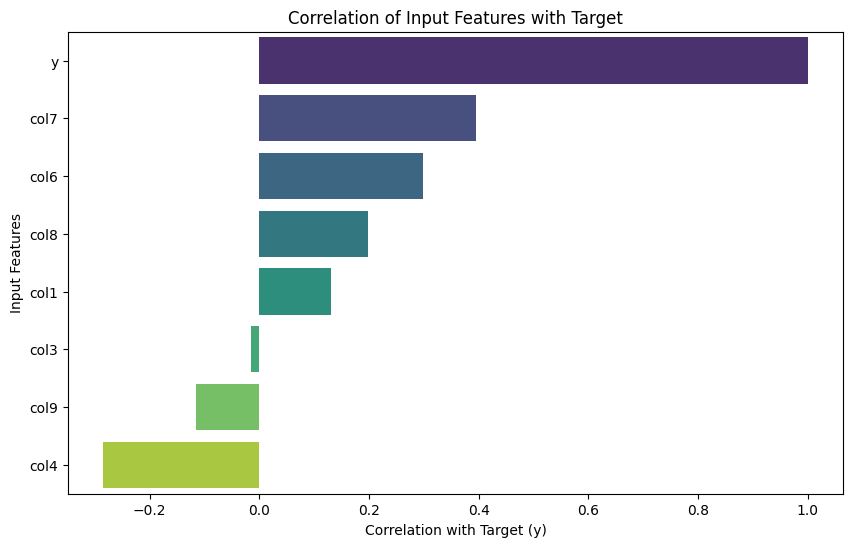

In [6]:
# Encoding categorical variables
encoded_train_data = train_data.copy()
for col in encoded_train_data.columns:
    if encoded_train_data[col].dtype == 'object':
        encoded_train_data[col] = LabelEncoder().fit_transform(encoded_train_data[col])

# Computing correlation coefficients between input columns and target column
correlation_with_target = encoded_train_data.drop('Id', axis=1).corr()['y'].sort_values(ascending=False)

# Plotting correlation values with respect to class variable
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
plt.xlabel('Correlation with Target (y)')
plt.ylabel('Input Features')
plt.title('Correlation of Input Features with Target')
plt.show()

In [7]:
# Combining the training and test data for label encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Handling categorical variables using Label Encoding
categorical_cols = [col for col in combined_data.columns if combined_data[col].dtype == 'object']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col])
    label_encoders[col] = le

# Separating the combined data back into X_train and X_test
X_train = combined_data[:len(X_train)]
X_test = combined_data[len(X_train):]

# Standardizing the continuous features
scaler = StandardScaler()
X_train.loc[:, ~X_train.columns.isin(categorical_cols)] = scaler.fit_transform(X_train.loc[:, ~X_train.columns.isin(categorical_cols)])
X_test.loc[:, ~X_test.columns.isin(categorical_cols)] = scaler.transform(X_test.loc[:, ~X_test.columns.isin(categorical_cols)])

# Printing shapes of datasets and splits
print("Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print()

# Converting categorical labels to numeric values for classification
label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)

Shapes:
X_train shape: (139652, 7)
X_test shape: (59852, 7)



In [ ]:
# Defining Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Feature Selection based on Feature Importance (XGBoost)
selector = SelectFromModel(XGBRegressor(random_state=42))
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Ensemble of Models (XGBoost, RandomForest, LightGBM)
xgb_regressor = XGBRegressor(random_state=42)
rf_regressor = RandomForestRegressor(random_state=42)
lgbm_regressor = LGBMRegressor(random_state=42, num_leaves=64)

models = [xgb_regressor, rf_regressor, lgbm_regressor]

# Hyperparameter Tuning (Grid Search) for XGBoost and LightGBM
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

best_classifier = None
best_avg_rmse = float('inf')

for model, param_grid in [(xgb_regressor, param_grid_xgb), (lgbm_regressor, param_grid_lgbm)]:
    mse_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train_encoded):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train_encoded[train_idx], y_train_encoded[val_idx]

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_fold, y_train_fold)

        best_params = grid_search.best_params_

        best_classifier = model.set_params(**best_params)
        best_classifier.fit(X_train_fold, y_train_fold)
        
        y_pred = best_classifier.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred)
        mse_scores.append(mse)

    avg_rmse = np.sqrt(np.mean(mse_scores))
    if avg_rmse < best_avg_rmse:
        best_avg_rmse = avg_rmse
        best_classifier = model

# Data Augmentation (Adding Noise to Features)
X_train_augmented = X_train_selected + np.random.normal(0, 0.01, size=X_train_selected.shape)

# Regularization (Ridge Regression)
from sklearn.linear_model import Ridge
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train_augmented, y_train)

# Learning Rate Scheduling and Early Stopping (XGBoost)
xgb_regressor = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

# Use learning rate scheduling with early stopping
eval_set = [(X_train_selected, y_train)]
xgb_regressor.fit(X_train_selected, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False, early_stopping_rounds=10)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 89376, number of used features: 2
[LightGBM] [Info] Start training from score 3208.536207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [11]:
best_classifier

LGBMRegressor(max_depth=5, n_estimators=300, num_leaves=64, random_state=42)

In [12]:
# Making Predictions using the Best Model
y_pred = best_classifier.predict(X_test_selected)


# # Convert encoded labels back to original categorical labels
# predicted_labels = label_encoder_y.inverse_transform(y_pred)

# # Create a DataFrame with ID and predicted labels
# predicted_df = pd.DataFrame({'Id': test_data['Id'], 'y': predicted_labels})
# # predicted_df = pd.DataFrame({'ID': X_test.index, 'y': predicted_labels}) #index from 0


# Preparing the predictions for submission
predicted_df = pd.DataFrame({'Id': test_data['Id'], 'y': y_pred})
predicted_df.to_csv('ensemble_predictions_XGB_rf_LGBM_DATA-AUG.csv', index=False)

# Printing shapes of datasets and splits
print("Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print()

Shapes:
X_train shape: (139652, 7)
y_train_encoded shape: (139652,)

X_test shape: (59852, 7)



In [ ]:
"""

# Split training data into training and validation sets for evaluation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

# Make predictions on the validation data
y_pred = best_classifier.predict(X_val)

# Generate classification report(precision, recall, and F1-score)
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=label_encoder_y.classes_, normalize=True, title=f'Normalized Confusion Matrix - {best_classifier.__class__.__name__}')
plt.show()

"""

XGBoost regressor with the best hyperparameters (Grid Search)
Highest Public score: 5671017705258.910156 on Kaggle Competition.

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings

# Ignoring warnings
warnings.simplefilter("ignore")

# Loading training dataset
train_data = pd.read_csv('train.csv')

# Splitting the training data into features (X_train) and target (y_train)
X_train = train_data.drop(['Id', 'y'], axis=1)
y_train = train_data['y']

# Loading test dataset
test_data = pd.read_csv('test.csv')


# Splitting the test data into features (X_test)
X_test = test_data.drop('Id', axis=1)

# Combining the training and test data for label encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Handling categorical variables using Label Encoding
categorical_cols = [col for col in combined_data.columns if combined_data[col].dtype == 'object']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col])
    label_encoders[col] = le

# Separating the combined data back into X_train and X_test
X_train = combined_data[:len(X_train)]
X_test = combined_data[len(X_train):]

# Standardizing the continuous features
scaler = StandardScaler()
X_train.loc[:, ~X_train.columns.isin(categorical_cols)] = scaler.fit_transform(X_train.loc[:, ~X_train.columns.isin(categorical_cols)])
X_test.loc[:, ~X_test.columns.isin(categorical_cols)] = scaler.transform(X_test.loc[:, ~X_test.columns.isin(categorical_cols)])

# Training an XGBoost regressor with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

xgb_regressor = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Training an XGBoost regressor with the best hyperparameters
best_xgb_regressor = XGBRegressor(n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  random_state=42)
best_xgb_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred_xgb = best_xgb_regressor.predict(X_test)

# Preparing the predictions for submission
submission_df = pd.DataFrame({'Id': test_data['Id'], 'y': y_pred_xgb})
submission_df.to_csv('xgb_predictions.csv', index=False)

LGBM regressor with the best hyperparameters (Grid Search)
Highest Public score: 5671017705258.910156 on Kaggle Competition same as XGBregressors result

In [15]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings

# Ignoring warnings
warnings.simplefilter("ignore")

# Loading training dataset
train_data = pd.read_csv('train.csv')

# Splitting the training data into features (X_train) and target (y_train)
X_train = train_data.drop(['Id', 'y'], axis=1)
y_train = train_data['y']

# Loading test dataset
test_data = pd.read_csv('test.csv')


# Splitting the test data into features (X_test)
X_test = test_data.drop('Id', axis=1)

# Combining the training and test data for label encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Handling categorical variables using Label Encoding
categorical_cols = [col for col in combined_data.columns if combined_data[col].dtype == 'object']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col])
    label_encoders[col] = le

# Separating the combined data back into X_train and X_test
X_train = combined_data[:len(X_train)]
X_test = combined_data[len(X_train):]

# Standardizing the continuous features
scaler = StandardScaler()
X_train.loc[:, ~X_train.columns.isin(categorical_cols)] = scaler.fit_transform(X_train.loc[:, ~X_train.columns.isin(categorical_cols)])
X_test.loc[:, ~X_test.columns.isin(categorical_cols)] = scaler.transform(X_test.loc[:, ~X_test.columns.isin(categorical_cols)])

# Training an LGBMRegressor with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

#xgb_regressor = XGBRegressor(random_state=42)
lgbm_regressor = LGBMRegressor(random_state=42, num_leaves=64)

grid_search = GridSearchCV(estimator=lgbm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Training an LGBM regressor with the best hyperparameters
best_lgbm_regressor = XGBRegressor(n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  random_state=42)
best_lgbm_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred_lgbm = best_lgbm_regressor.predict(X_test)

# Preparing the predictions for submission
submission_df = pd.DataFrame({'Id': test_data['Id'], 'y': y_pred_xgb})
submission_df.to_csv('lgbm_predictions.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 111721, number of used features: 7
[LightGBM] [Info] Start training from score 1241326.848874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-thread

LGBMRegressor(max_depth=5, n_estimators=300, num_leaves=64, random_state=42) #best parameters same as the first approach
from ensemble predictions of XGB,RF and LGBM (DATA-AUGMENTATION adding noise) + only k (5) fold
2nd highest Public score: 5779074097340.769531 on Kaggle Competition


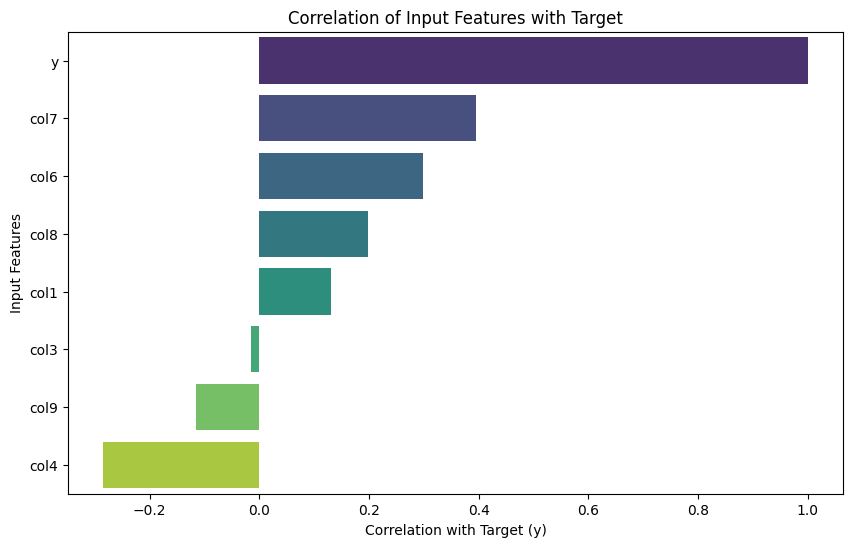

Shapes:
X_train shape: (139652, 7)
X_test shape: (59852, 7)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 89376, number of used features: 2
[LightGBM] [Info] Start training from score 1241681.177990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

import itertools
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Loading training dataset
train_data = pd.read_csv('train.csv')

train_data.head()

# Splitting the training data into features (X_train) and target (y_train)
X_train = train_data.drop(['Id', 'y'], axis=1)
y_train = train_data['y']

# Load test dataset
test_data = pd.read_csv('test.csv')

test_data.head()

# Splitting the test data into features (X_test)
X_test = test_data.drop('Id', axis=1)

# Encoding categorical variables
encoded_train_data = train_data.copy()
for col in encoded_train_data.columns:
    if encoded_train_data[col].dtype == 'object':
        encoded_train_data[col] = LabelEncoder().fit_transform(encoded_train_data[col])

# Computing correlation coefficients between input columns and target column
correlation_with_target = encoded_train_data.drop('Id', axis=1).corr()['y'].sort_values(ascending=False)

# Plotting correlation values with respect to class variable
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
plt.xlabel('Correlation with Target (y)')
plt.ylabel('Input Features')
plt.title('Correlation of Input Features with Target')
plt.show()

# Combining the training and test data for label encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Handling categorical variables using Label Encoding
categorical_cols = [col for col in combined_data.columns if combined_data[col].dtype == 'object']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col])
    label_encoders[col] = le

# Separating the combined data back into X_train and X_test
X_train = combined_data[:len(X_train)]
X_test = combined_data[len(X_train):]

# Standardizing the continuous features
scaler = StandardScaler()
X_train.loc[:, ~X_train.columns.isin(categorical_cols)] = scaler.fit_transform(X_train.loc[:, ~X_train.columns.isin(categorical_cols)])
X_test.loc[:, ~X_test.columns.isin(categorical_cols)] = scaler.transform(X_test.loc[:, ~X_test.columns.isin(categorical_cols)])

# Printing shapes of datasets and splits
print("Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print()

# Converting categorical labels to numeric values for classification
label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)

# Implementing K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Feature Selection based on Feature Importance (XGBoost)
selector = SelectFromModel(XGBRegressor(random_state=42))
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Ensemble of Models (XGBoost, RandomForest, LightGBM)
xgb_regressor = XGBRegressor(random_state=42)
rf_regressor = RandomForestRegressor(random_state=42)
lgbm_regressor = LGBMRegressor(random_state=42, num_leaves=64)

models = [xgb_regressor, rf_regressor, lgbm_regressor]

# Hyperparameter Tuning (Grid Search) for XGBoost and LightGBM
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

best_classifier = None
best_avg_rmse = float('inf')

for model, param_grid in [(xgb_regressor, param_grid_xgb), (lgbm_regressor, param_grid_lgbm)]:
    mse_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train_encoded):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train_encoded[train_idx], y_train_encoded[val_idx]

    for train_idx, val_idx in kf.split(X_train_selected):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_fold, y_train_fold)

        best_params = grid_search.best_params_

        best_classifier = model.set_params(**best_params)
        best_classifier.fit(X_train_fold, y_train_fold)
        
        y_pred = best_classifier.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred)
        mse_scores.append(mse)

    avg_rmse = np.sqrt(np.mean(mse_scores))
    if avg_rmse < best_avg_rmse:
        best_avg_rmse = avg_rmse
        best_classifier = model

# Data Augmentation (Adding Noise to Features)
X_train_augmented = X_train_selected + np.random.normal(0, 0.01, size=X_train_selected.shape)

# Regularization (Ridge Regression)
from sklearn.linear_model import Ridge
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train_augmented, y_train)

# Learning Rate Scheduling and Early Stopping (XGBoost)
xgb_regressor = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

# Using learning rate scheduling with early stopping
eval_set = [(X_train_selected, y_train)]
xgb_regressor.fit(X_train_selected, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False, early_stopping_rounds=10)

best_classifier

# Making Predictions using the Best Model
y_pred = best_classifier.predict(X_test_selected)


# # Converting encoded labels back to original categorical labels
# predicted_labels = label_encoder_y.inverse_transform(y_pred)

# # Creating a DataFrame with ID and predicted labels
# predicted_df = pd.DataFrame({'Id': test_data['Id'], 'y': predicted_labels})
# # predicted_df = pd.DataFrame({'ID': X_test.index, 'y': predicted_labels}) #index from 0


# Preparing the predictions for submission
predicted_df = pd.DataFrame({'Id': test_data['Id'], 'y': y_pred})
predicted_df.to_csv('ensemble_predictions_XGB_rf_LGBM_DATA-AUG_k-Fold.csv', index=False)

# Printing shapes of datasets and splits
print("Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print()

In [17]:
best_classifier

LGBMRegressor(max_depth=5, n_estimators=300, num_leaves=64, random_state=42)